In [1]:
import os
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix

# Read the Data

In [2]:
working_directory = os.getcwd()
print(working_directory)
data = pd.read_csv(f"{working_directory}/Input_Data/creditcard_post_correlation.csv") #Change the path to your dataset, if needed

c:\Users\teovr\Desktop\Projects\Predicting_Fraudulent_Transactions_With_Machine_Learning


## Define Predictors and Target Variables
##### We will specify the predictor features and the target variable. Additionally, categorical features can be identified if present. In this case, there are no categorical features.



In [3]:
# Define the target variable
target = 'Fraud_Flag'

# Define the features to be used in the model
predictors = [
    'Transaction_Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
    'Transaction_Amount'
]

## Define the TRAIN/VALIDATION/TEST SPLIT

In [ ]:
#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 # Number of boosting rounds for XGBoost
EARLY_STOP = 50 # Early stopping rounds for XGBoost
VERBOSE_EVAL = 50 # Print out metric result every 50 rounds

# Set the path to the input data
IS_LOCAL = True  # Set to True since you we running locally

if IS_LOCAL:
    PATH = (f"{working_directory}/Input_Data/")
else:
    PATH = "../input"

print(os.listdir(PATH))  # List the files in the specified directory

['creditcard.csv', 'creditcard_cleaned.csv', 'creditcard_post_correlation.csv', 'creditcard_post_exploration.csv', 'download_data_link.txt']


## Split data in train, test and validation set

In [5]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

# Further split the training set into training and validation sets
train_df, valid_df = train_test_split(
    train_df, 
    test_size=VALID_SIZE, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

## XGBoost

#### XGBoost is a gradient boosting algorithm

### Prepare the model
##### initialize the DMatrix objects for training and validation, starting from the datasets  and set some of the parameters used for the model tuning.

In [7]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['eta'] = 0.039
xgb_params['silent'] = True
xgb_params['max_depth'] = 2
xgb_params['subsample'] = 0.8
xgb_params['colsample_bytree'] = 0.9
xgb_params['eval_metric'] = 'auc'
xgb_params['random_state'] = RANDOM_STATE

### Train the model

In [8]:
model = xgb.train(xgb_params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

C:\Users\teovr\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
C:\Users\teovr\AppData\Roaming\Python\Python312\site-packages\xgboost\callback.py:386: UserWarning: [00:51:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-auc:0.93758	valid-auc:0.88823
[50]	train-auc:0.98426	valid-auc:0.97736
[100]	train-auc:0.99063	valid-auc:0.98039
[148]	train-auc:0.99333	valid-auc:0.97755


##### The best validation score (ROC-AUC) was 0.98039, for round 100.

### Features importance

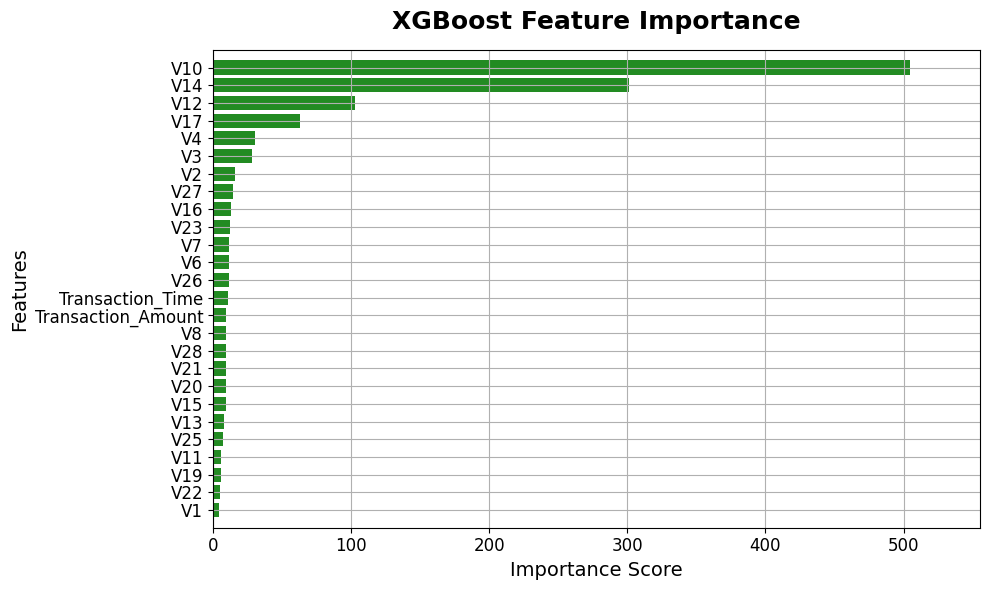

In [9]:
# Make predictions
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(
    model,
    ax=ax,
    height=0.8,
    title="Feature Importance (XGBoost)",
    color="forestgreen",
    importance_type='gain',  
    show_values=False,       
)

# Add value labels to bars 
ax.set_title("XGBoost Feature Importance", fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel("Importance Score", fontsize=14)
ax.set_ylabel("Features", fontsize=14)

# Plot the feature importance
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


### Predict test set

In [10]:
predictions4 = model.predict(dtest)

### Confusion Matrix

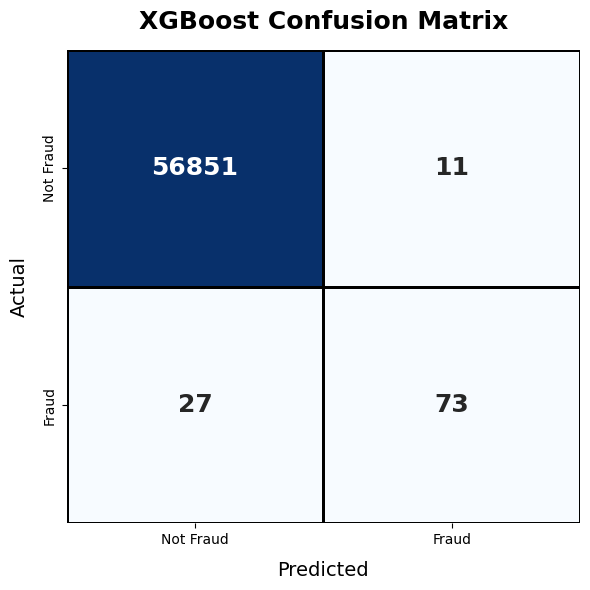

In [11]:
# Convert predicted probabilities to class labels (0 or 1)
xgb_pred_labels = (predictions4 >= 0.5).astype(int)

# Create the confusion matrix
cm_xgb = confusion_matrix(test_df[target].values, xgb_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(
    cm_xgb,
    annot=True,
    fmt='d',
    cmap="Blues",
    linewidths=1,
    linecolor="black",
    cbar=False,
    xticklabels=['Not Fraud', 'Fraud'],
    yticklabels=['Not Fraud', 'Fraud'],
    annot_kws={"size": 18, "weight": "bold"}
)

# Add title and labels
plt.title('XGBoost Confusion Matrix', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Predicted', fontsize=14, labelpad=10)
plt.ylabel('Actual', fontsize=14, labelpad=10)
plt.tight_layout()
plt.show()

### Success Metrics

- **Accuracy**: The proportion of total predictions that were correct.
- **Precision**: The proportion of positive identifications that were actually correct (minimizes false positives).
- **Recall (Sensitivity)**: The proportion of actual positives that were correctly identified (minimizes false negatives).
- **F1 Score**: The harmonic mean of precision and recall, providing a balance between the two.
- **ROC-AUC Score**: Measures the model's ability to distinguish between classes across all thresholds. A higher ROC-AUC indicates better overall classification performance, especially important for imbalanced datasets.
- **Classification Report**: A detailed summary including precision, recall, F1-score, and support for each class.

These metrics provide a more comprehensive view of model performance, especially for imbalanced datasets like fraud detection.

In [12]:
# Calculate and print evaluation metrics
def print_metrics(y_true, y_pred, dataset_name):
    print(f"--- {dataset_name} Metrics ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred):.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Not Fraud", "Fraud"]))
    print("\n")

# Get predictions for each set (convert probabilities to class labels)
train_pred_xgb = (model.predict(xgb.DMatrix(train_df[predictors])) >= 0.5).astype(int)
valid_pred_xgb = (model.predict(xgb.DMatrix(valid_df[predictors])) >= 0.5).astype(int)
test_pred_xgb = (model.predict(xgb.DMatrix(test_df[predictors])) >= 0.5).astype(int)

# Print metrics
print_metrics(train_df[target].values, train_pred_xgb, "Train")
print_metrics(valid_df[target].values, valid_pred_xgb, "Validation")
print_metrics(test_df[target].values, test_pred_xgb, "Test")

--- Train Metrics ---
Accuracy: 0.9995
Precision: 0.8839
Recall: 0.8138
F1 Score: 0.8474
ROC-AUC Score: 0.9068

Classification Report:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    181986
       Fraud       0.88      0.81      0.85       290

    accuracy                           1.00    182276
   macro avg       0.94      0.91      0.92    182276
weighted avg       1.00      1.00      1.00    182276



--- Validation Metrics ---
Accuracy: 0.9992
Precision: 0.9000
Recall: 0.7059
F1 Score: 0.7912
ROC-AUC Score: 0.8529

Classification Report:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     45467
       Fraud       0.90      0.71      0.79       102

    accuracy                           1.00     45569
   macro avg       0.95      0.85      0.90     45569
weighted avg       1.00      1.00      1.00     45569



--- Test Metrics ---
Accuracy: 0.9993
Precision: 0.8690
Recall: 0

### Explanation of Evaluation Metrics

The following metrics are used to evaluate the performance of the XGBoost classifier on the fraud detection task:

- **Accuracy**: The proportion of total predictions that were correct. In imbalanced datasets, accuracy can be misleading, as a model can achieve high accuracy by simply predicting the majority class.

- **Precision**: The proportion of positive predictions (fraud) that were actually correct. High precision means that when the model predicts fraud, it is usually correct. Important when the cost of a false positive is high.

- **Recall (Sensitivity)**: The proportion of actual fraud cases that were correctly identified. High recall means the model detects most frauds. Important when missing a fraud case is costly.

- **F1 Score**: The harmonic mean of precision and recall. It balances the trade-off between precision and recall, especially useful for imbalanced datasets.

- **ROC-AUC Score**: Measures the model's ability to distinguish between classes across all thresholds. A higher ROC-AUC indicates better overall performance.

- **Classification Report**: Provides a detailed breakdown of precision, recall, F1-score, and support for each class (fraud and not fraud).

**Note:** In fraud detection, recall and ROC-AUC are often prioritized, as it is crucial to identify as many fraudulent transactions as possible, even if it means accepting some false positives.